<a href="https://colab.research.google.com/github/miguel-angel-monjas/mlops-zoomcamp/blob/main/week_1/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages import

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

## Q1.Downloading the data

In [3]:
!pwd

/home/ubuntu/Projects/mlops/week_1


In [4]:
!mkdir -p data
!mkdir -p models

In [5]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -O data/fhv_tripdata_2021-01.parquet
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -O data/fhv_tripdata_2021-02.parquet

--2022-05-30 00:07:19--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.69.76
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.69.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886281 (11M) [binary/octet-stream]
Saving to: ‘data/fhv_tripdata_2021-01.parquet’

data/fhv_tripdata_2 100%[===================>]  11,33M  4,31MB/s    in 2,6s    

2022-05-30 00:07:22 (4,31 MB/s) - ‘data/fhv_tripdata_2021-01.parquet’ saved [11886281/11886281]

--2022-05-30 00:07:23--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.69.76
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.69.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10645466 (10M) [binary/octet-stream]
Saving to: ‘data/fhv_tripdata_2021-02.parque

In [6]:
january_df = pd.read_parquet("data/fhv_tripdata_2021-01.parquet")
february_df = pd.read_parquet("data/fhv_tripdata_2021-02.parquet")

In [7]:
january_df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


In [8]:
january_df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [9]:
january_rides_number = len(january_df)
january_rides_number

1154112

**Q1**: 1154112

## Q2. Computing duration

In [10]:
january_df['duration'] = january_df['dropOff_datetime'] - january_df['pickup_datetime']
january_df['duration'] = january_df['duration'].apply(lambda x: x.total_seconds() / 60)

Let's try to plot a histogram of the duration. As working with one million rows is difficult, let's use a sample

<AxesSubplot:xlabel='duration', ylabel='Count'>

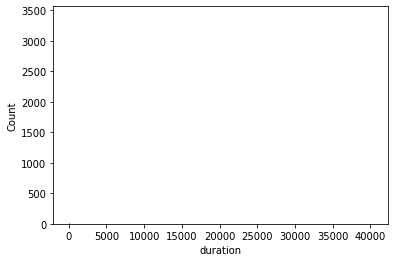

In [11]:
sns.histplot(january_df.sample(frac=0.10), x='duration')

There seems to be weird outliers (more than 17500 seconds?)

In [12]:
january_df['duration'].max()

423371.05

In [13]:
january_df['duration'].describe(percentiles=[0.95,0.98,0.99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

**Q2**: 19.16

## Data preparation

In [14]:
january_df = january_df[(january_df['duration'] >= 1) & (january_df['duration'] <= 60)]

In [15]:
january_rides_number - len(january_df)

44286

44286 rides have been dropped

<AxesSubplot:xlabel='duration', ylabel='Count'>

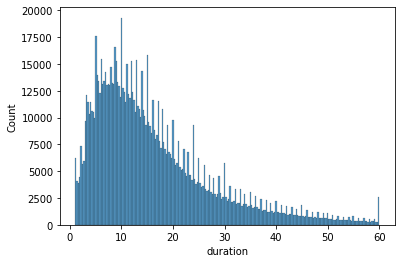

In [16]:
sns.histplot(january_df, x='duration')

## Q3. Missing values

In [17]:
january_rides_number = len(january_df)
pickup_location_nan = january_df['PUlocationID'].isnull().sum()

round((pickup_location_nan*100)/january_rides_number, 2)

83.53

In [18]:
january_df[['PUlocationID', 'DOlocationID']] = january_df[['PUlocationID', 'DOlocationID']].fillna(value=-1)

/tmp/ipykernel_8291/2484106316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_df[['PUlocationID', 'DOlocationID']] = january_df[['PUlocationID', 'DOlocationID']].fillna(value=-1)


In [19]:
january_df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


**Q3**: 83%

## Q4. One-hot encoding

In [20]:
january_df.drop(january_df.columns.difference(['PUlocationID', 'DOlocationID', 'duration']), axis=1, inplace=True)

/tmp/ipykernel_8291/2124166376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_df.drop(january_df.columns.difference(['PUlocationID', 'DOlocationID', 'duration']), axis=1, inplace=True)


In [21]:
categorical = ['PUlocationID', 'DOlocationID']
january_df[categorical] = january_df[categorical].astype('str')
train_dicts = january_df[categorical].to_dict(orient='records')

/tmp/ipykernel_8291/1452489375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_df[categorical] = january_df[categorical].astype('str')


In [22]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = january_df[target].values

In [23]:
X_train.shape

(1109826, 525)

**Q4**: 525

## Q5. Training a model

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False) # If True, returns MSE value; if False, returns RMSE value.

10.528519388409808

**Q5**: 10.53

/home/ubuntu/anaconda3/envs/mlops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/mlops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


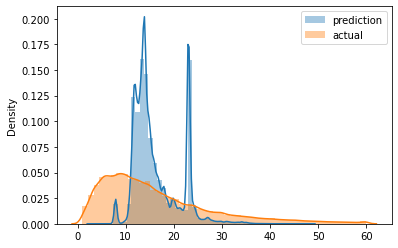

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Q6. Evaluating the model

In [26]:
february_df.shape

(1037692, 7)

In [27]:
categorical = ['PUlocationID', 'DOlocationID']
def process_dataframe(df, categorical):
  df = df.copy(deep=True)
  df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
  df['duration'] = df['duration'].apply(lambda x: x.total_seconds() / 60)

  df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

  df[categorical] = df[categorical].astype(str)
  
  return df

In [28]:
df = process_dataframe(february_df, categorical)
df.shape

(990113, 8)

In [29]:
test_dicts = df[categorical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

target = 'duration'
y_test = df[target].values

In [30]:
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

11.36412144000296

**Q6**: 11.36

## Saving the model

In [31]:
filename = 'linreg.bin.sav'
joblib.dump(lr, os.path.join(os.getcwd(), 'models', filename))

['/home/ubuntu/Projects/mlops/week_1/models/linreg.bin.sav']